# <p style="text-align:center;"> Unsupervised Learning </p>

**Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

from PIL import Image
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

**Functions**

In [3]:
def galaxy_morf(row):
    if row["elliptical"]:
        return "E"
    elif row["spiral"]:
        return "S"
    else:
        return "I"
    
def distribution_per_type(df, col_name="", bins=20):
    #]plt.title(f"{col_name.capitalize()} Distribution")
    sns.distplot(df[df["elliptical"] == 1][col_name],label="elliptical", bins=bins)
    sns.distplot(df[df["spiral"] == 1][col_name],label="spiral", bins=bins)
    sns.distplot(df[df["uncertain"] == 1][col_name],label="irregular", bins=bins)
    plt.legend()
    
def exploratory_plots(df, col_name=""):
    plt.subplot(3, 1, 1)
    distribution_per_type(df, col_name)
    plt.subplot(3, 1, 2)
    #plt.title(f"{col_name.capitalize()} Boxplot")
    sns.boxplot(x="type", y=col_name, data=df, **box_params)
    plt.subplot(3, 1, 3)
   # plt.title(f"{col_name.capitalize()} Boxplot w/o Outliers")
    sns.boxplot(x="type", y=col_name, data=df, showfliers=False, **box_params)
    
    plt.tight_layout()
    
def num_type(row):
    if row["type"] == "I":
        return 1
    elif row["type"] == "S":
        return 2
    else:
        return 3

def plot_silouette(silhouette_values, cluster_labels, silhouette_avg, 
                   title="Visualizacion de los datos"):
    fig, ax1 = plt.subplots(1, 1)
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    for i in np.unique(cluster_labels):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color   = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    # ax1.set_xlabel("espacio de la primera caracteristica")
    # ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

# 1- Dataset
The dataset to use is called curated_galaxies. The original dataset, 'galaxies_1.csv' consists of 92,102 records and 14 variables and has no missing values.

The variables are: `objID`, `'ra'`, `'dec'`, `'modelMag_u'`, `'modelMag_g'`, `'modelMag_r'`, `'modelMag_i'`,
`'modelMag_z'`, `'petroR90_r'`, `'z'`, `'Color'`, `'elliptical'`, `'spiral'` and `'uncertain'`.

The preprocessing used was previously done in the notebook "Exploration-Visualization-Curation"
and below the cleaning and curation implemented is summarized step by step.

## 1.1- Data Preparation

A column is added with the class of each galaxy, assigning the label 'I' (for irregular) to the
galaxies tagged 'uncertain'.
The 'objID' column is set as the id of the dataframe.
34421 objects with repeated id were found. Because our dataset is
large enough and to avoid conflicts between data, we decided to eliminate duplicates and the
dataset is left with 57681 data, which we consider that, for our purposes, is a quantity
enough to perform statistics.

#### 1.1.1- KNN imputation

Column values that fall outside an interval defined by a lower bound and an upper bound were imputed using KNN. the lower bound chosen for the apparent luminous magnitudes (`'modelMag_u'`, `'modelMag_g'`, `'modelMag_r'`, `'modelMag_i'`,
`'modelMag_z'`) and for the size (`'petroR90_r'`) was 0, color outliers were also filtered. The upper limits applied to the apparent magnitudes were chosen according to the criterion;

`'modelMag_u'`=22.0,

`'modelMag_g'`=22.2,

`'modelMag_r'`=22.2,

`'modelMag_i'`=21.3,

`'modelMag_z'`=20.5

Extracted from https://classic.sdss.org/dr4/

The data was scaled and imputation was performed using all columns as input.

#### 1.1.2-  Outliers Elimination

Finally, the outliers were eliminated using the criterion Q1*2.5 < x < Q3*2.5 and the
dataframe was saved in csv as "curated_galaxies".
	





**Load**

In [4]:
data = pd.read_csv('curated_galaxies') 

# Clases
data["type"] = data.apply(galaxy_morf, axis=1)


# variable Númerica**

data["type_n"] = data.apply(num_type, axis=1)


display(data.head(2))
display (data.shape)
data.describe()

,Unnamed: 0,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,clase,type,type_n
0,0,"1,23765119242489E+018",116.519097,39.886407,0.396231,0.417569,0.448185,0.416475,0.450813,0.309874,0.717351,0.648141,0,1,0,S,S,2
1,1,"1,23765149575578E+018",116.451900,41.421270,0.447561,0.354289,0.326150,0.290167,0.299840,0.365343,0.673681,0.375909,0,0,1,I,I,1


(56545, 18)

,Unnamed: 0,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,type_n
count,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000,56545.000000
mean,41881.743815,183.402710,25.400552,0.482438,0.452570,0.455663,0.418586,0.445480,0.337935,0.536541,0.534350,0.073163,0.339782,0.587055,1.486108
std,26118.804710,57.709405,18.622262,0.126569,0.127546,0.131967,0.124335,0.136140,0.174565,0.282370,0.106292,0.260406,0.473639,0.492368,0.629397
min,0.000000,0.008745,-11.202394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19357.000000,151.364561,10.506527,0.398104,0.365542,0.363388,0.330434,0.347292,0.210154,0.303909,0.441027,0.000000,0.000000,0.000000,1.000000
50%,39347.000000,183.904718,23.910305,0.494381,0.472302,0.477013,0.438235,0.466167,0.305997,0.541897,0.551587,0.000000,0.000000,1.000000,1.000000
75%,63495.000000,221.679881,39.433792,0.573036,0.554660,0.565233,0.521477,0.557679,0.429129,0.787953,0.618387,0.000000,1.000000,1.000000,2.000000
max,92099.000000,359.965567,70.133213,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [5]:
data['elliptical'].unique()

array([0, 1], dtype=int64)

# Clustering

## Stratified Sample

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2411)

In [7]:
for train_idx, test_idx in sss.split(data, data["type_n"]):
    #strat_train_set = data_cl.loc[train_idx]
    strat_test_set  = data.iloc[test_idx]

Análisis sin variables de ubicación y tipo

In [8]:
type_cols      = ['ra','dec','objID','elliptical', 'spiral', 'uncertain', 'type', 'type_n','clase']

# escalar
data_clus      = strat_test_set.drop(type_cols, axis=1)
data_clus_cols = data_clus.columns
data_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11309 entries, 11896 to 25654
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11309 non-null  int64  
 1   modelMag_u  11309 non-null  float64
 2   modelMag_g  11309 non-null  float64
 3   modelMag_r  11309 non-null  float64
 4   modelMag_i  11309 non-null  float64
 5   modelMag_z  11309 non-null  float64
 6   petroR90_r  11309 non-null  float64
 7   z           11309 non-null  float64
 8   Color       11309 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 883.5 KB


In [9]:
data_clus      = pd.DataFrame(data=StandardScaler().fit_transform(data_clus), 
                             columns=data_clus_cols)

data_clus

,Unnamed: 0,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color
0,-0.977426,1.068111,1.168508,1.372123,1.509737,1.546975,0.103924,-0.728974,0.891493
1,-1.292241,-1.289694,-1.739543,-1.831119,-1.835765,-1.849695,2.108399,0.117923,-1.422963
2,-1.271869,-0.119483,-0.453977,-0.481621,-0.448782,-0.435462,0.494192,-0.420203,-0.753112
3,-1.555857,-0.115509,0.377317,0.558853,0.657372,0.688259,-0.983156,-1.409070,1.313269
4,1.550051,-1.678747,-1.826147,-1.749705,-1.719013,-1.682952,2.305685,-0.780016,-0.589458
...,...,...,...,...,...,...,...,...,...
11304,0.728033,-0.496364,-0.364693,-0.320543,-0.357153,-0.441024,0.600454,0.118936,0.218145
11305,0.073666,-1.496670,-2.126923,-2.254748,-2.247547,-2.244111,1.899721,-0.743961,-1.909952
11306,1.722987,-2.051200,-1.811957,-1.627460,-1.560411,-1.506916,0.581859,0.960105,0.296802
11307,0.632222,0.426431,0.582221,0.667580,0.695000,0.714664,0.305021,0.267321,0.594828


### K-Means

K-means is an unsupervised Clustering algorithm, whose objective is to group each data in our dataset into k disjoint clusters. The number of clusters is a parameter, and the centroid of each cluster can be initialized randomly or chosen manually if you have domain knowledge that allows you to do so (among other ways). Then each datapoint is assigned to the cluster whose centroid is closest (the aim is to minimize the inertia or the sum of squares of each cluster). Then the geometric mean of each cluster is calculated and assigned as the new centroid. With this centroid, the previous steps are repeated until reaching a criterion that can be convergence (the centroids do not vary significantly), or maximum iterations. Finally, the clusters that have minimized the sum of squares within each cluster are chosen.
Note that each time the process is repeated, different results can be obtained since the model is susceptible to the initial location of the centroids, so convergence is not guaranteed.

The silhouette method allows us to measure, using the silhouette coefficient, how strong the identification of a data and its cluster is with respect to other clusters.

In [10]:
range_n_clusters = [2, 3, 4, 5, 6, 7]

def serch_k_optimus(data_clus, range_n_clusters):
    sse = {}
    for n_clusters in range_n_clusters:
        
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        
        # "Start fitting"
        cluster_labels = clusterer.fit_predict(data_clus)
        
        # "Stop fitting"
        sse[n_clusters] = clusterer.inertia_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data_clus, cluster_labels, random_state=352)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_clus, cluster_labels)

        plot_silouette(sample_silhouette_values, cluster_labels,
                       silhouette_avg, title="k={}".format(n_clusters))
    return sse


C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 2 El silhouette_score promedio es : 0.35683246573725275


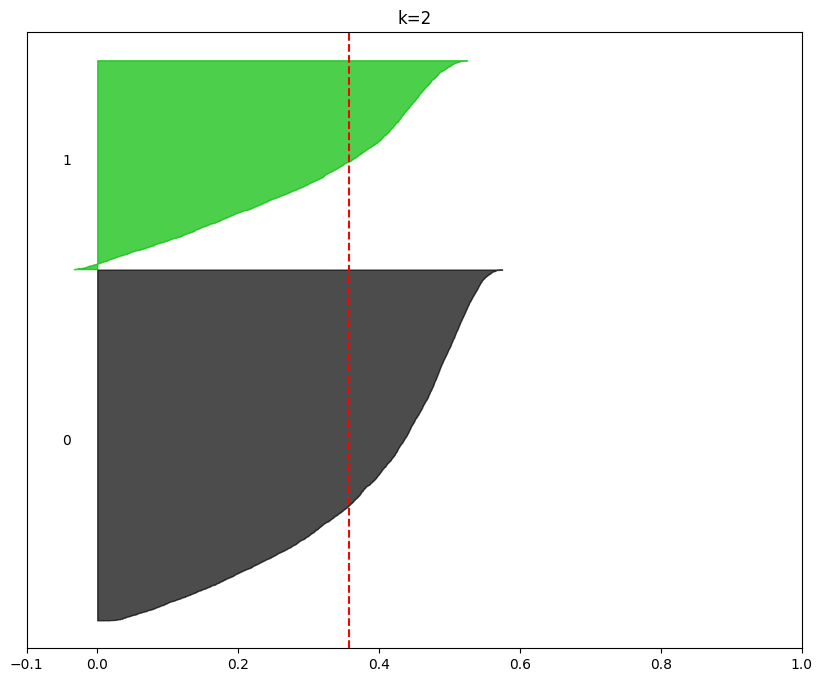

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 3 El silhouette_score promedio es : 0.23748030477207363


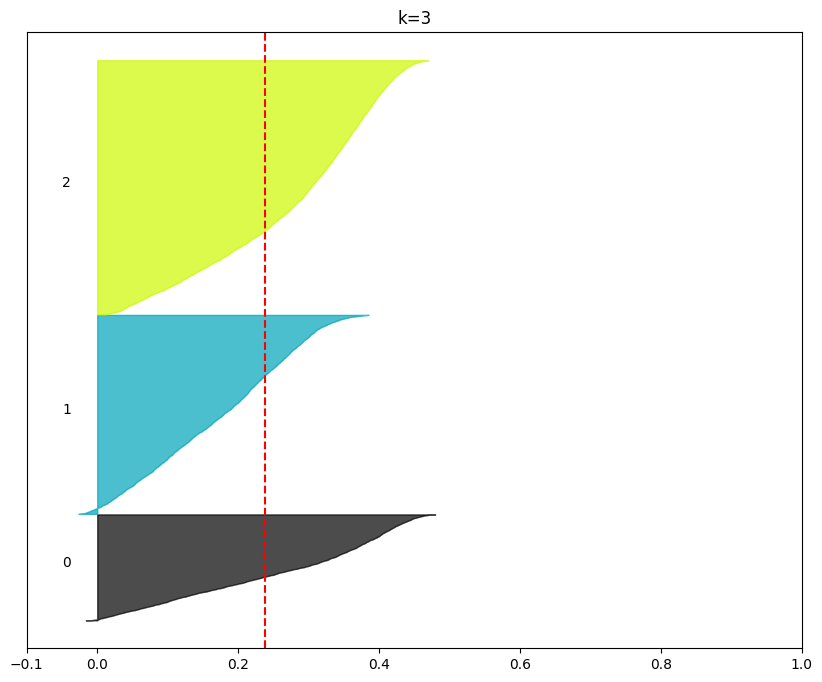

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 4 El silhouette_score promedio es : 0.1950660843119573


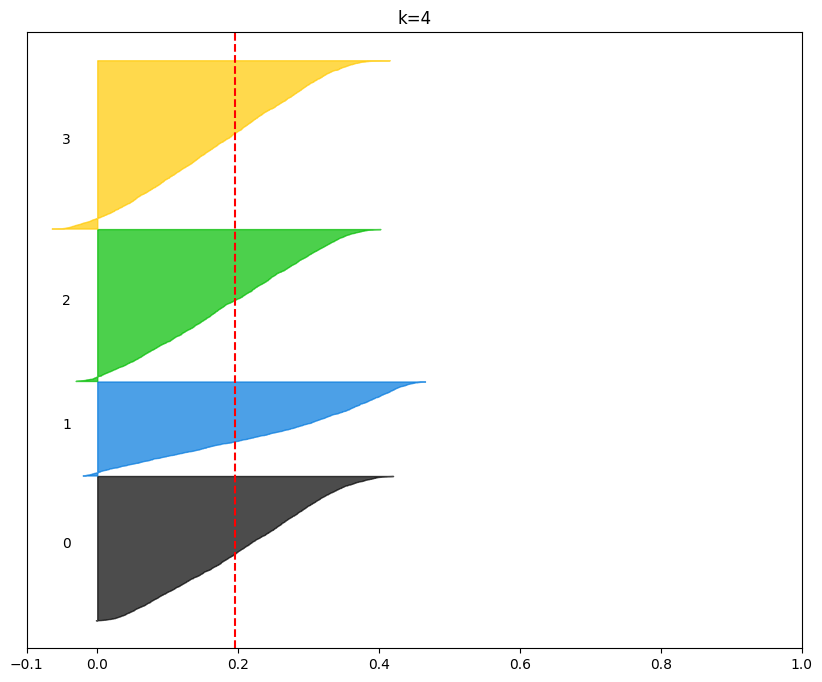

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 5 El silhouette_score promedio es : 0.1906499883234374


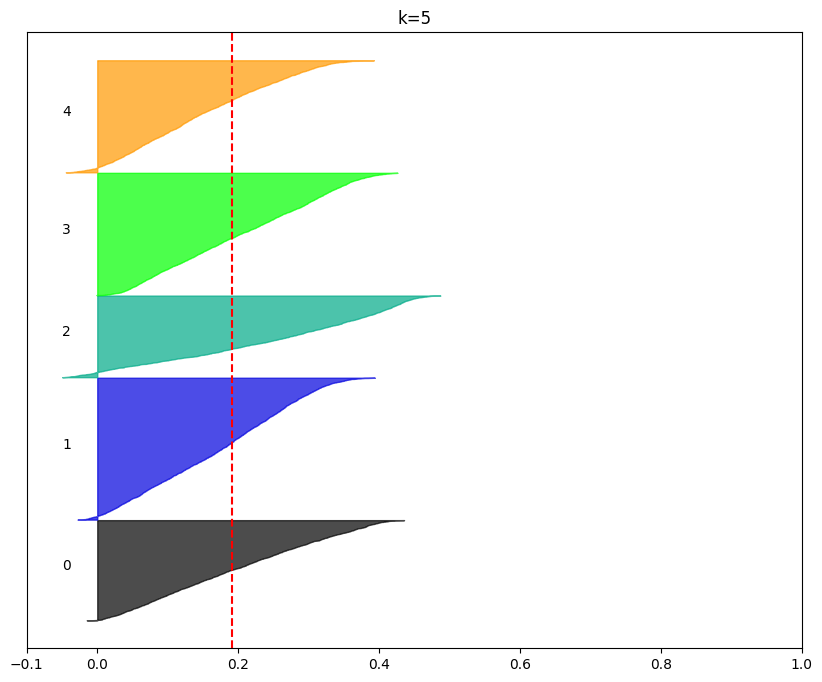

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 6 El silhouette_score promedio es : 0.18268314237017758


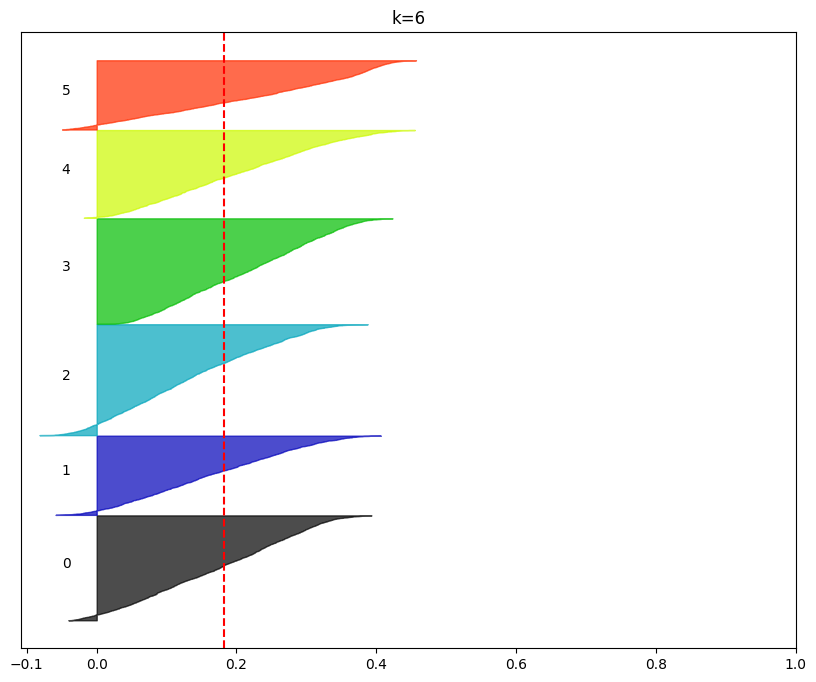

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para n_clusters = 7 El silhouette_score promedio es : 0.18640155995496027


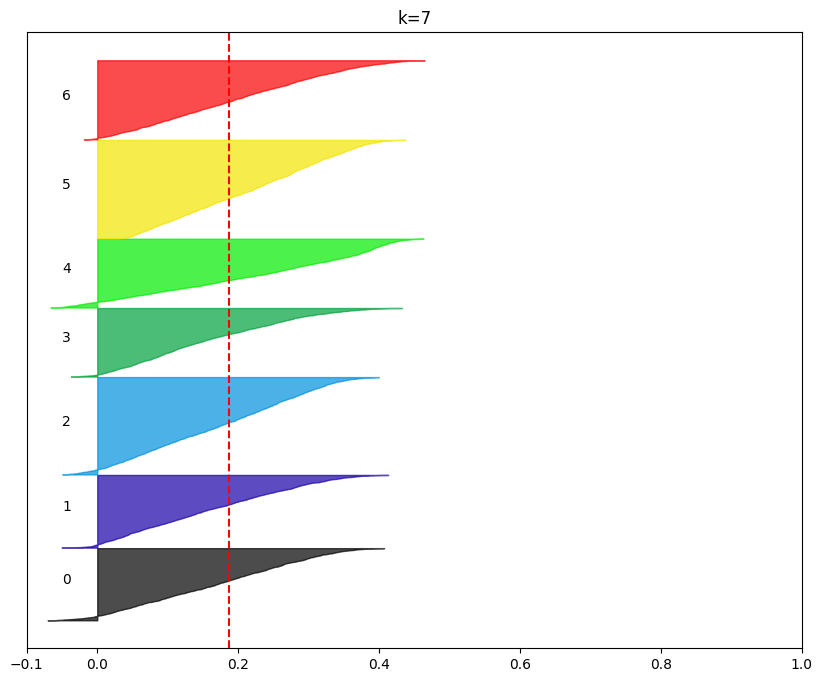

In [11]:
sse = serch_k_optimus(data_clus, range_n_clusters)

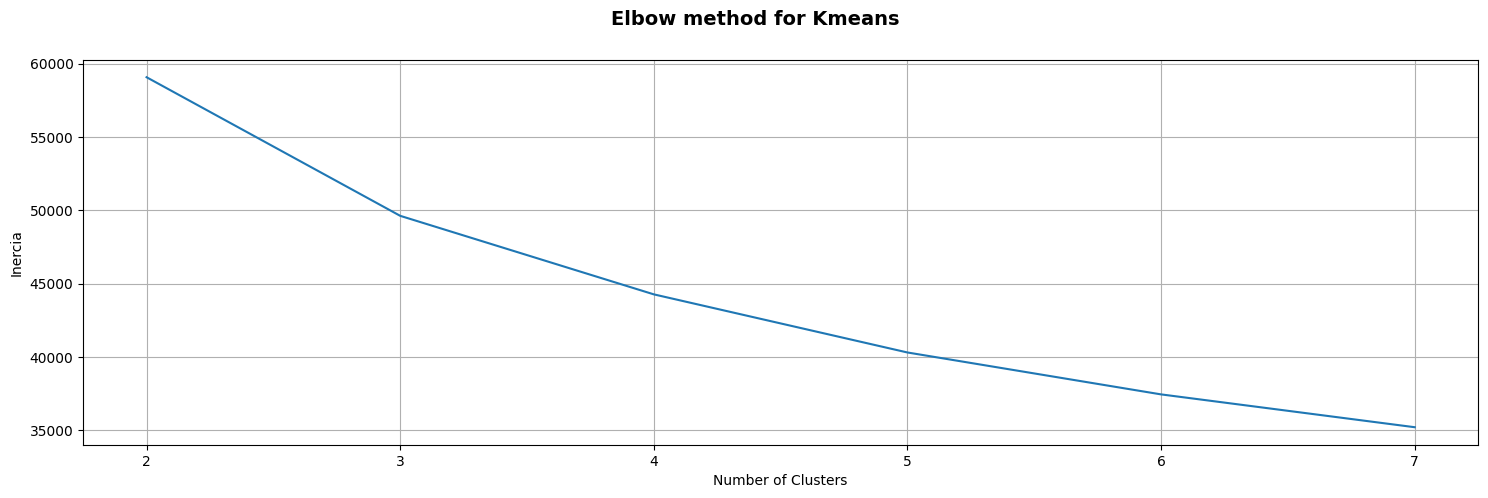

In [12]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 5)
plt.suptitle(("Elbow method for Kmeans "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inercia")
plt.grid()

The silhouette graphs shown above show the silhouette score of each point in each cluster. The more uniform and long each silhouette is, the better the data is identified with its respective clusters. The bigger the score the better

In our case it seems that k=3 is a good number of clusers to choose from, with a score of 0.2805523577032078. 2 clusters is also a good option, with the best score of all 0.39953428584614104. K=4 its a posibility if may be we want to study more in detail the possible subclasses inside de Irregular class, that we somewhat saw in the previous notebook.

the score decreases slowly from k=4, this suggests that taking k>4 leads to nowhere.

The elbow method sugest that k=3 is the optimal way of clustering.

### K=3 

Now let's delve into some basic analysis of clusters when k=3

In [13]:
K= 3
cluster_K = KMeans(n_clusters=K, random_state=10)
cluster_labels_K = cluster_K.fit_predict(data_clus)

data_clus["cluster_label"] = cluster_labels_K

C:\Users\joaqu\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualizacion by cluster label

In [14]:
def distribution_per_label(df, col_name="", bins=20):
    plt.title(f'{col_name.capitalize()} Distribution')
    for kk in df["cluster_label"].unique():
        sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}', 
                     bins=bins)
    plt.legend()
    
def exploratory_plots_label(df, col_name=""):
    plt.subplot(2, 1, 1)
    distribution_per_label(df, col_name)
    plt.subplot(2, 1, 2)
    #plt.title(f"{col_name.capitalize()} Boxplot w/o Outliers")
    sns.boxplot(x="cluster_label", y=col_name, data=df, showfliers=False)
    
    plt.tight_layout()

### Color

C:\Users\joaqu\AppData\Local\Temp\ipykernel_12472\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}',
C:\Users\joaqu\AppData\Local\Temp\ipykernel_12472\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

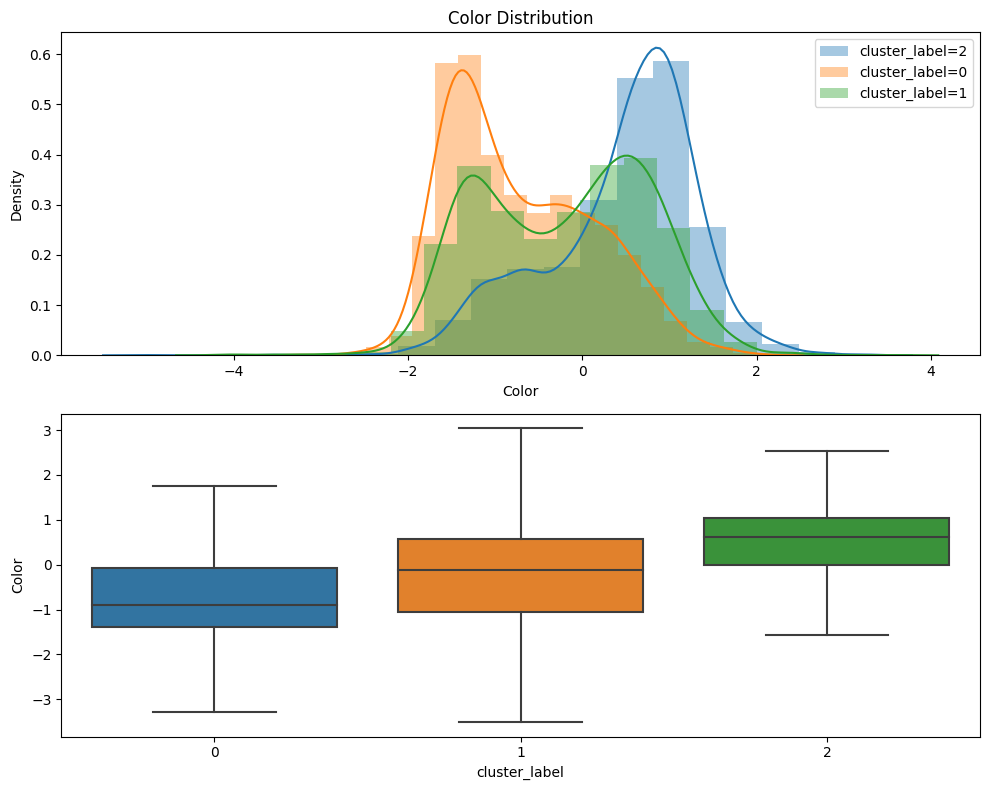

In [15]:
exploratory_plots_label(data_clus, "Color")

We can compare the image above with the one below. We can see that it seems that the cluster 2 and 0 may be conformed by the two sublcasses of irregular galaxies, but this requiers further exploration and is just an informed opinion that could lead somewhere. We can also see that the cluster 1 has a bimodality, suggesting that know this cluster may be conformed by two sublcasses.
 This shows that k=3 may not be as explanatory as we desire.

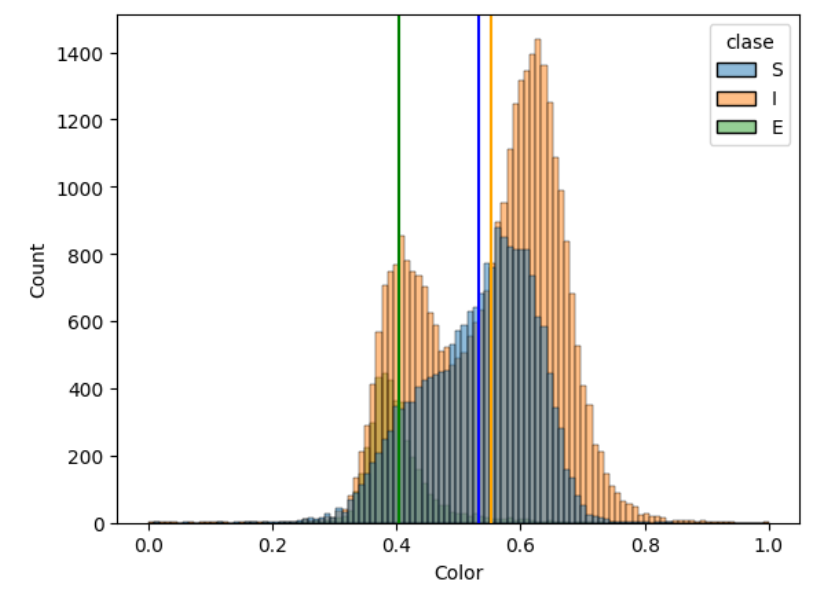

In [40]:
img = Image.open('assets/color.png')
display(img)

### Petro R90

C:\Users\joaqu\AppData\Local\Temp\ipykernel_12472\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}',
C:\Users\joaqu\AppData\Local\Temp\ipykernel_12472\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

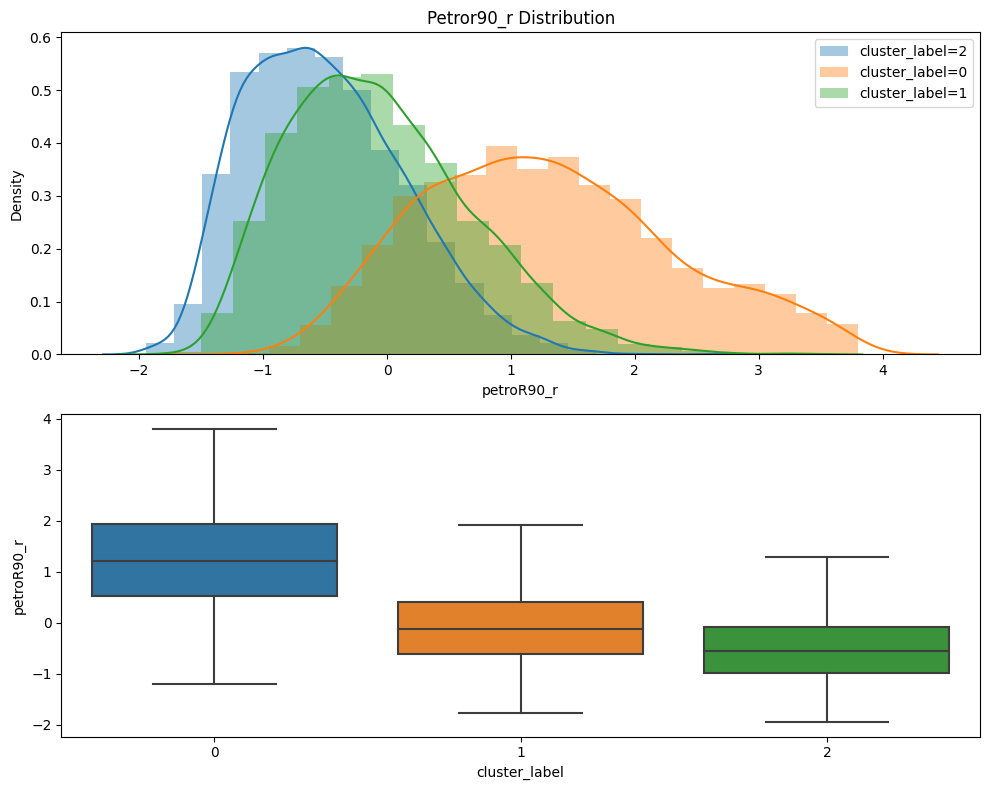

In [41]:
exploratory_plots_label(data_clus, "petroR90_r")

### Mag Distributions

C:\Users\joaqu\AppData\Local\Temp\ipykernel_12472\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["cluster_label"] == kk][col_name],label=f'cluster_label={kk}',
C:\Users\joaqu\AppData\Local\Temp\ipykernel_12472\533041309.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

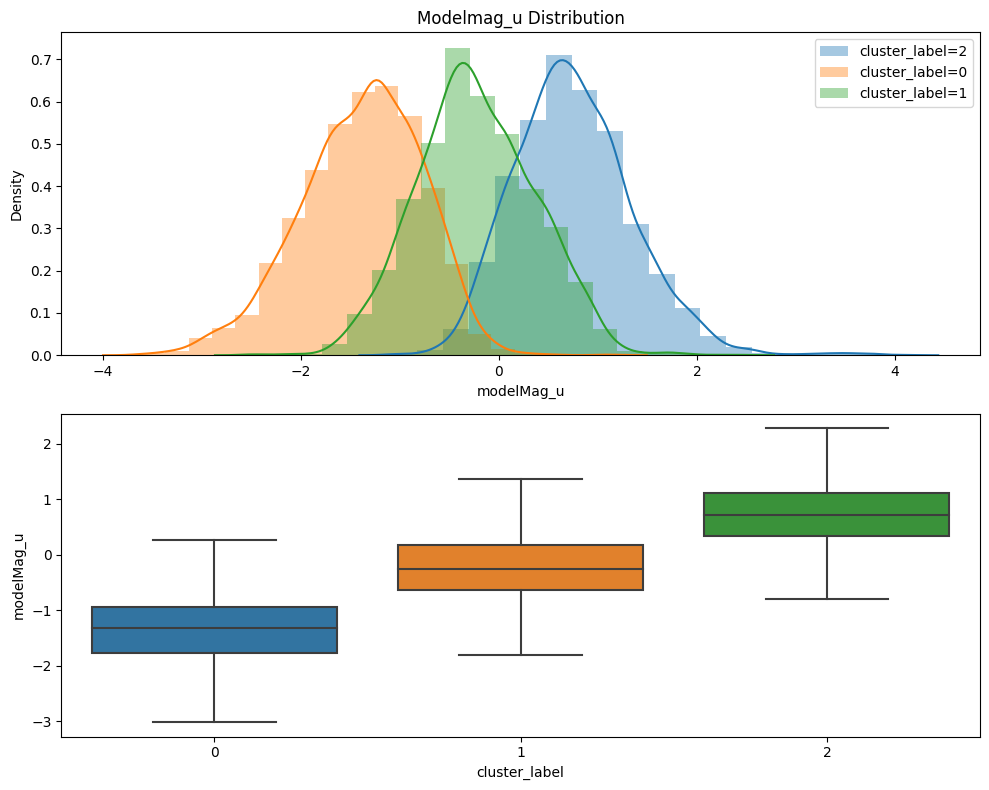

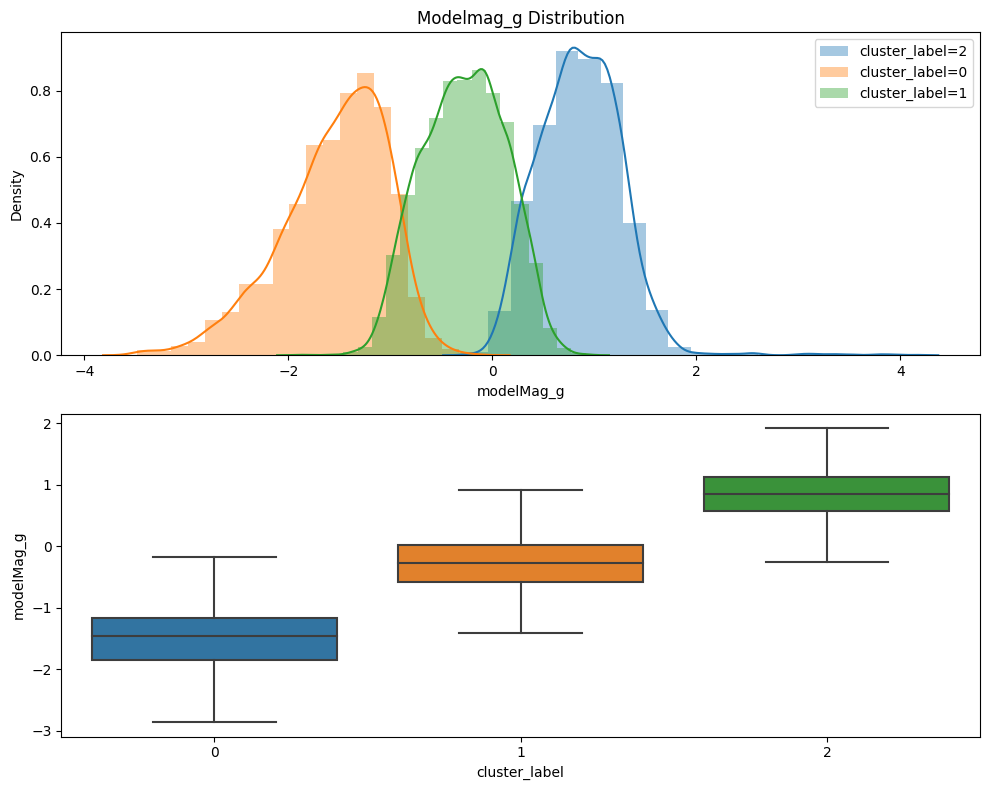

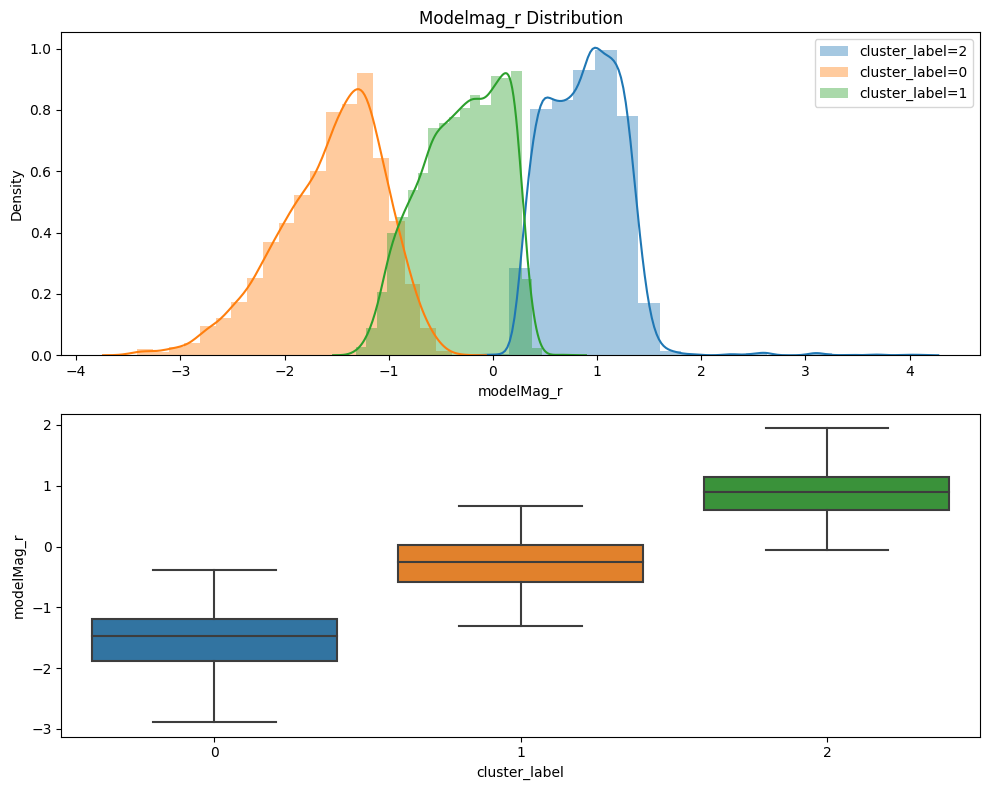

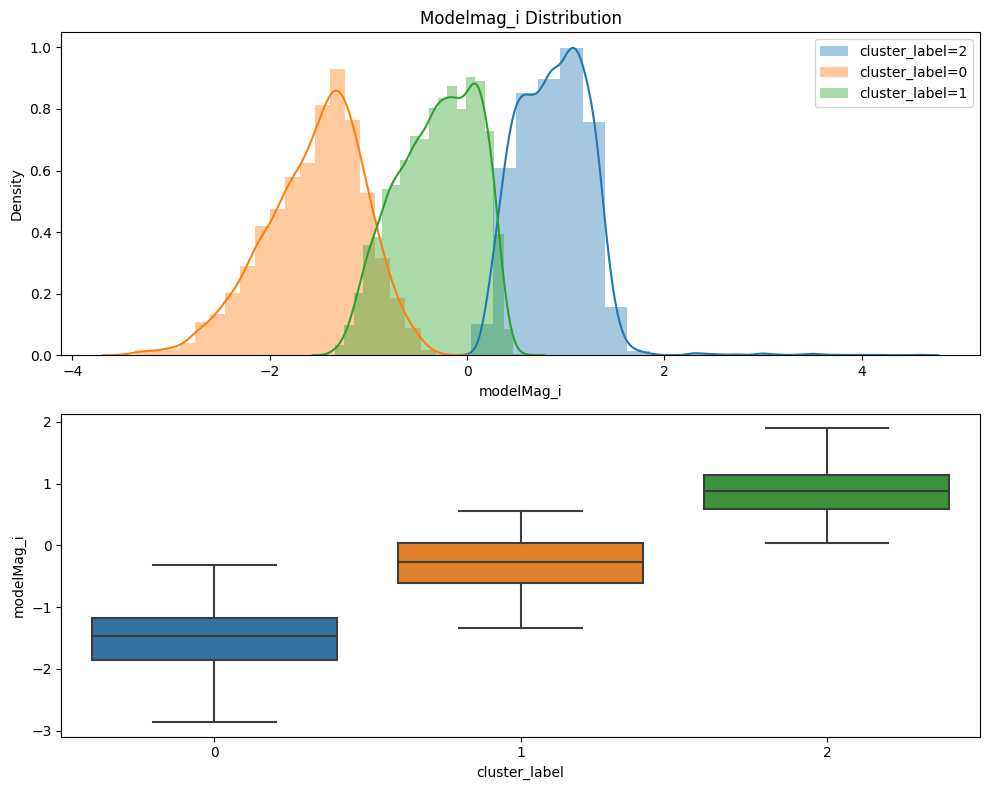

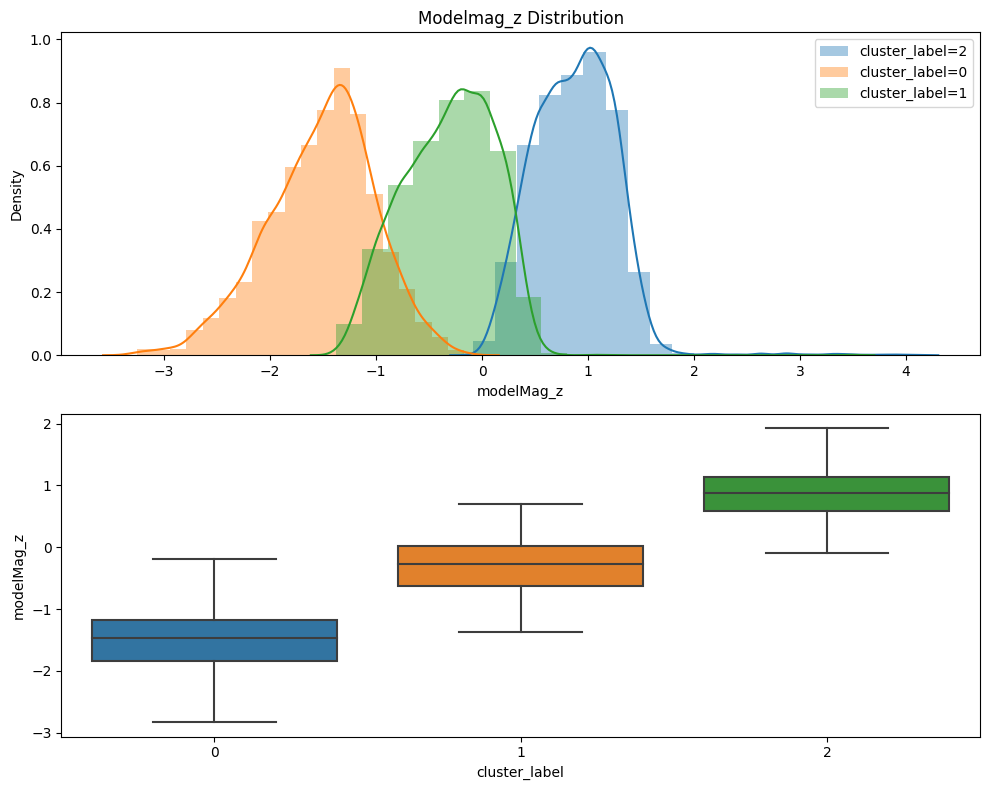

In [42]:
for mag in ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']:
    plt.figure()
    exploratory_plots_label(data_clus, mag)

## What can be said about previous graphs?

### color
With respect to the color graph, significant differences are observed between clusters 0 and 1. Cluster 2 is also observed with bimodality, this may suggest that cluster 2 may in turn be made up of two subclusters.
The graph is very similar to the one obtained when the distribution of the color class was visualized, distinguishing by galaxy class, done in deliverable 1 of the subject.
### Petro R90
The boxplots again show a clear separation between clusters 0 and 1, suggesting that cluster 0 corresponds to the largest galaxies with a more reddish color index, while cluster 1 corresponds to small and bluish galaxies.
Cluster 2 contains galaxies with perhaps more average and more spread out values.
### Magnitudes
The boxplots of all magnitudes show clear separation of clusters, with cluster 0 corresponding to the weakest galaxies in their corresponding magnitude, followed by cluster 2 which again seems to have an average value, and finally cluster 1 with the weakest values. highs of magnitude u, again following the trend.

The trend seems to be summarized as follows:

Cluster 0: Small, bluish and dim galaxies.

Cluster 1: Large, reddish and bright galaxies.

Cluster 2: Galaxies that do not fall into the previous clusters and have rather average values ​​or non-extreme values.

In [43]:
data_clus['cluster_label'].value_counts()

2    5141
1    4026
0    2142
Name: cluster_label, dtype: int64

In [44]:
data_clus_N = data_clus
data_clus_N.columns

Index(['Unnamed: 0', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroR90_r', 'z', 'Color', 'cluster_label'],
      dtype='object')

# Embeddings

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [46]:
def print_title(title="", delimiter="*"):
    print(delimiter*80)
    print(title)
    print(delimiter*80)

In [47]:
def plot_3d(pca, df, colname=""):
    from mpl_toolkits.mplot3d import Axes3D 
    fig = plt.figure(figsize=(15, 10))
    for idx in range(1, 5):
        ax = fig.add_subplot(2,2,idx, projection='3d')
        im = ax.scatter(pca[:,0], pca[:,1], pca[:,2], 
               c = df[colname], cmap=plt.get_cmap("jet"),
                        alpha=0.5)
        ax.view_init(30, 45+90*idx)
        ax.set_xlabel("Axis 1")
        ax.set_ylabel("Axis 2")
        ax.set_zlabel("Axis 3")
        fig.colorbar(im, ax=ax)

In [48]:
def plot_2d(pca, df, colname=""):
    from mpl_toolkits.mplot3d import Axes3D 
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    im = ax.scatter(pca[:,0],pca[:,1],
                    c=df[colname],cmap=plt.get_cmap("jet"),
                    alpha=0.5)
    ax.set_xlabel("Axis 1")
    ax.set_ylabel("Axis 2")
    fig.colorbar(im, ax=ax)

## PCA

In Pca the same trend mentioned above is observed, cluster 2 seems to be between cluster 0 and 1.
There seems to be a clear separation of classes, at least areas with significant density of a predominant class.

In [49]:
pca_3dim = PCA(n_components=3)
pca_2dim = PCA(n_components=2)


pca_std_3d = pca_3dim.fit_transform(data_clus_N)
pca_std_2d = pca_2dim.fit_transform(data_clus_N)


In [50]:
print_title("3D")
print("nombre_modelo", pca_3dim.explained_variance_ratio_, sum(pca_3dim.explained_variance_ratio_))

print_title("2D")
print("nombre_modelo", pca_2dim.explained_variance_ratio_, sum(pca_2dim.explained_variance_ratio_))


********************************************************************************
3D
********************************************************************************
nombre_modelo [0.61411393 0.14193113 0.1039288 ] 0.8599738556297465
********************************************************************************
2D
********************************************************************************
nombre_modelo [0.61411393 0.14193113] 0.7560450570434634


In [51]:
axis_components = pd.DataFrame(index=data_clus.columns, columns=["Ax1", "Ax2", "Ax3"], 
                                  data=pca_3dim.components_.T)

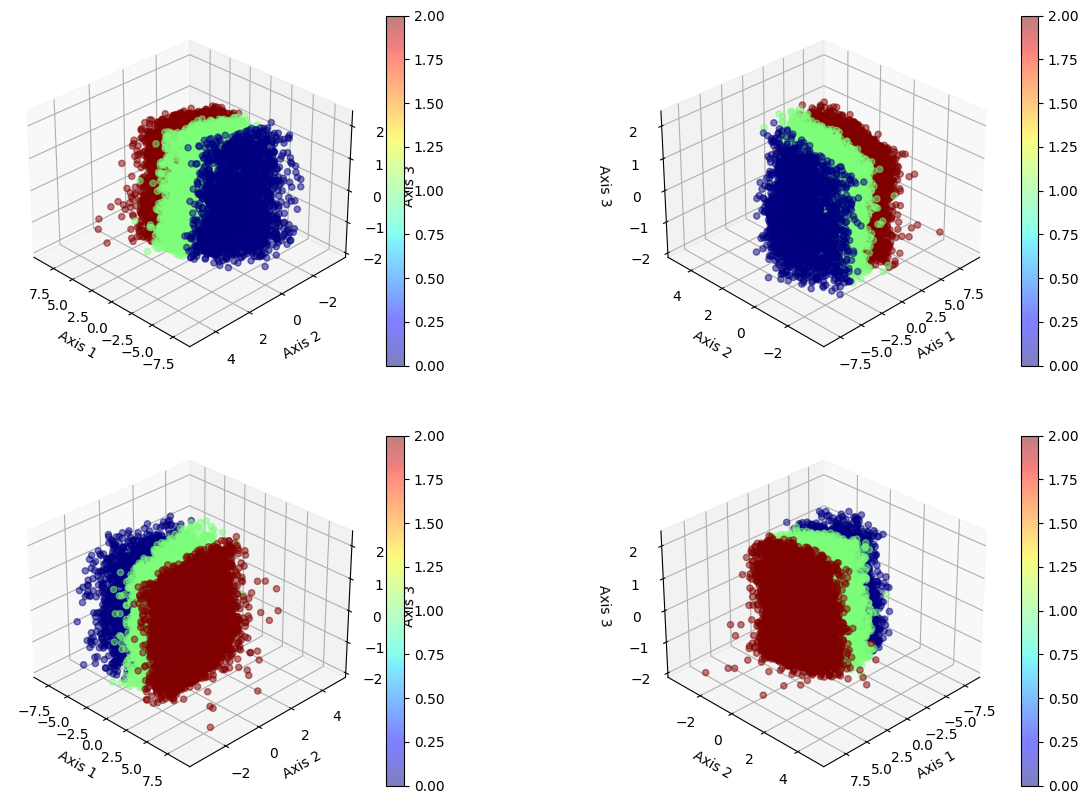

In [52]:
plot_3d(pca_std_3d, data_clus_N, "cluster_label")

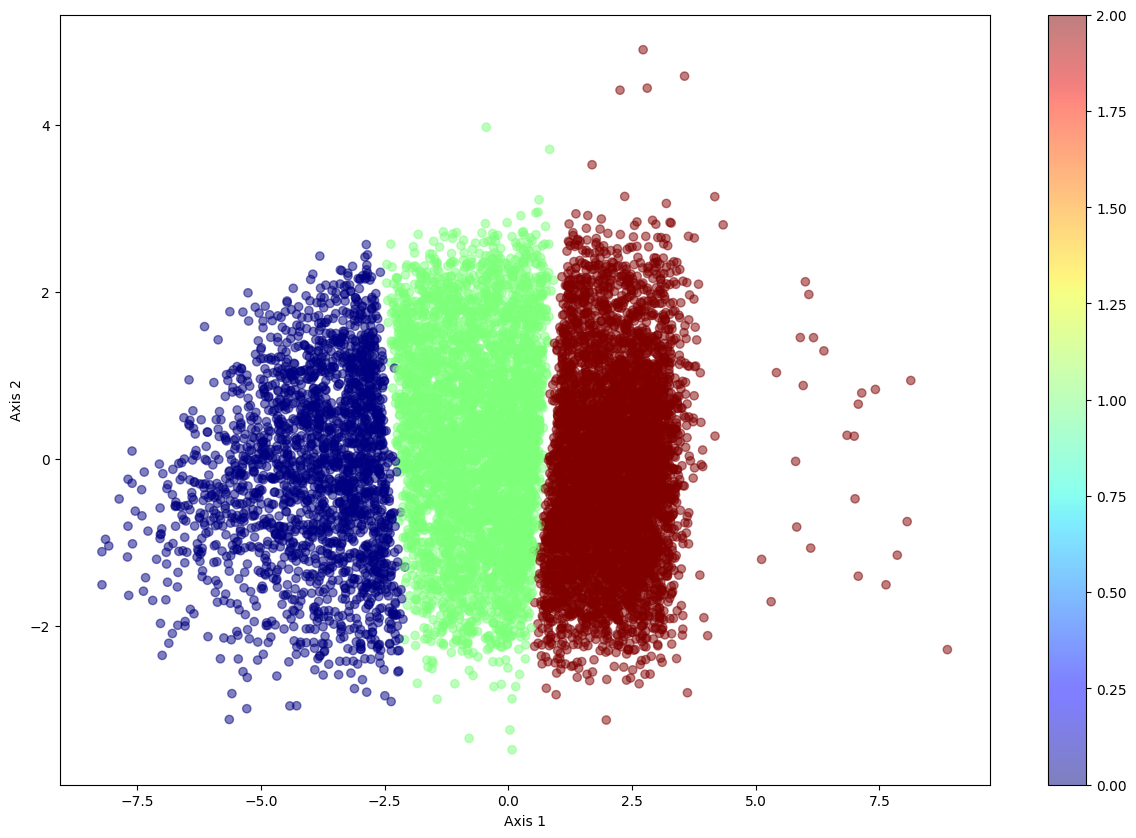

In [53]:
plot_2d(pca_std_2d, data_clus_N, "cluster_label")

## TSNE

On the other hand, in TSNE a clear class separation is observed

In [54]:
tsne_2dim = TSNE(n_components=2, )
tsne_std = tsne_2dim.fit_transform(data_clus_N)

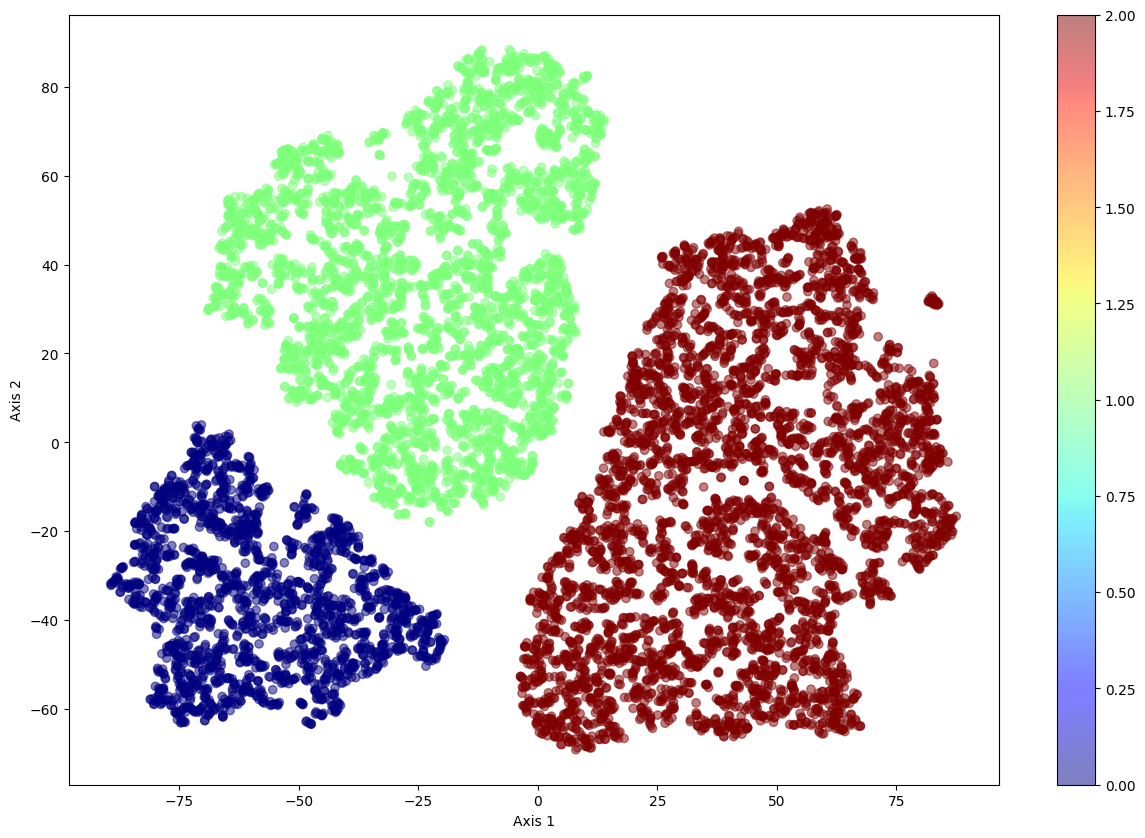

In [55]:
plot_2d(tsne_std, data_clus_N, "cluster_label")

#### This analysis could be taken further by exploring others values for k and diving deeper into the analysis, but for the moment we can keep it simple.